<div align="center">
<h1>Graph Sage classification for Cora data</h1>
    <img src="https://production-media.paperswithcode.com/datasets/Cora-0000000700-ce1c5ec7_LD7pZnT.jpg" width=500>
</div>

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.4 MB/s eta 0:00:0000:01


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid # The citation network datasets “Cora”, “CiteSeer” and “PubMed”
from torch_geometric.nn import SAGEConv
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



# Importing Data

In [3]:
path = "./input"  # Directory to download dataset
dataset = Planetoid(path, "Cora") # Download the dataset
data = dataset[0] # Tensor representation of the Cora-Planetoid data
print('Cora: ', data)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Processing...


Cora:  Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


# Node2Vec Model Construction

In [4]:
SAGE_model = SAGEConv(in_channels= data.num_features, # Number of features
                   out_channels= dataset.num_classes, # Dimension of embedding
                   )

print(" Shape of the original data: ", data.x.shape)
print(" Shape of SAGE the embedding data: ", SAGE_model(data.x,data.edge_index).shape)

 Shape of the original data:  torch.Size([2708, 1433])
 Shape of SAGE the embedding data:  torch.Size([2708, 7])


# Embedding Visualization with T-SNE

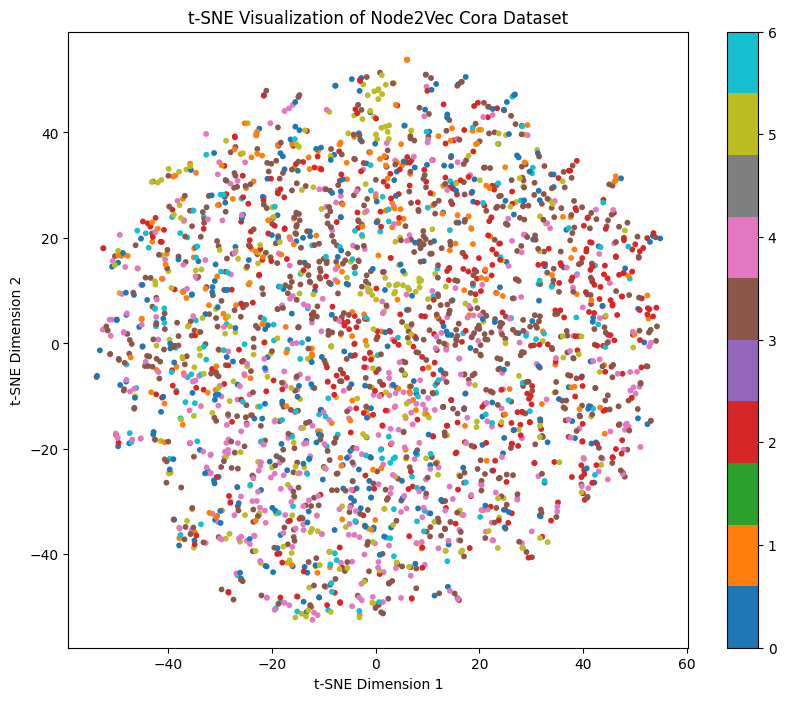

In [5]:
# Get node embeddings
embeddings = SAGE_model(data.x,data.edge_index).detach().cpu().numpy()

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2)  # Change n_components to 3 for 3D visualization
embedding_tsne = tsne.fit_transform(embeddings)


# Plot the nodes
plt.figure(figsize=(10, 8))
plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c=data.y, cmap='tab10', s=10)
plt.title('t-SNE Visualization of Node2Vec Cora Dataset')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()
plt.show()

# SAGE Classification Model

In [6]:
class SAGE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        """ SAGEConv layers """
        self.conv1 = SAGEConv(data.num_features, 16)
        self.conv2 = SAGEConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAGE_model, data = SAGE().to(device), data.to(device)
optimizer = torch.optim.Adam(SAGE_model.parameters(), lr=0.01, weight_decay=5e-4)

# What are the learning parameters:
for i, parameter in SAGE_model.named_parameters():
    print(" Parameter {}".format(i))
    print("Shape: ",parameter.shape)

 Parameter conv1.lin_l.weight
Shape:  torch.Size([16, 1433])
 Parameter conv1.lin_l.bias
Shape:  torch.Size([16])
 Parameter conv1.lin_r.weight
Shape:  torch.Size([16, 1433])
 Parameter conv2.lin_l.weight
Shape:  torch.Size([7, 16])
 Parameter conv2.lin_l.bias
Shape:  torch.Size([7])
 Parameter conv2.lin_r.weight
Shape:  torch.Size([7, 16])


# Train and Test functions

In [7]:
def SAGEtrain():
    SAGE_model.train() # Set the model.training to be True
    optimizer.zero_grad() # Reset the gradient
    predicted_y = SAGE_model(data) # predicted y in log softmax prob
    true_y = data.y # True labels
    losses = F.nll_loss(predicted_y[data.train_mask], true_y[data.train_mask])
    losses.backward()
    optimizer.step() # Update the parameters such that is minimized the losses


def SAGEtest():
    SAGE_model.eval() # Set the model.training to be False
    logits = SAGE_model(data) # Log prob of all data
    accs = []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1] #Transforming log prob to actual labels
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

# Application

SAGE Epoch: 001, Train: 0.6500, Val: 0.2540, Test: 0.2540
SAGE Epoch: 002, Train: 0.9714, Val: 0.4840, Test: 0.4660
SAGE Epoch: 003, Train: 0.9929, Val: 0.5520, Test: 0.5450
SAGE Epoch: 004, Train: 1.0000, Val: 0.5740, Test: 0.5840
SAGE Epoch: 005, Train: 1.0000, Val: 0.6220, Test: 0.6250
SAGE Epoch: 006, Train: 1.0000, Val: 0.6500, Test: 0.6460
SAGE Epoch: 007, Train: 1.0000, Val: 0.6860, Test: 0.6690
SAGE Epoch: 008, Train: 1.0000, Val: 0.7000, Test: 0.6900
SAGE Epoch: 009, Train: 1.0000, Val: 0.7320, Test: 0.7260
SAGE Epoch: 010, Train: 1.0000, Val: 0.7460, Test: 0.7440
SAGE Epoch: 011, Train: 1.0000, Val: 0.7520, Test: 0.7530
SAGE Epoch: 012, Train: 1.0000, Val: 0.7540, Test: 0.7620
SAGE Epoch: 013, Train: 1.0000, Val: 0.7560, Test: 0.7660
SAGE Epoch: 014, Train: 1.0000, Val: 0.7640, Test: 0.7730
SAGE Epoch: 015, Train: 1.0000, Val: 0.7740, Test: 0.7740
SAGE Epoch: 016, Train: 1.0000, Val: 0.7760, Test: 0.7790
SAGE Epoch: 017, Train: 1.0000, Val: 0.7800, Test: 0.7780
SAGE Epoch: 01

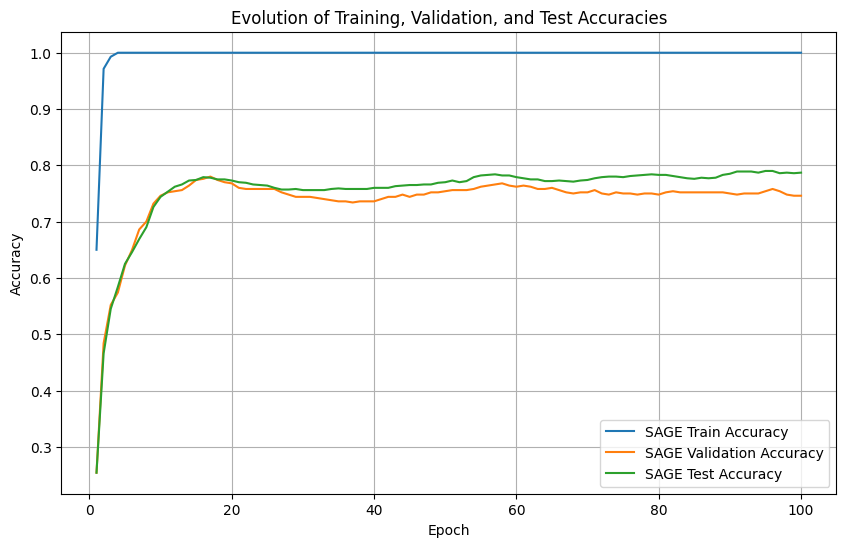

In [8]:

# Initialize lists to store accuracies

SAGE_train_accs = []
SAGE_val_accs = []
SAGE_test_accs = []


SAGE_best_val_acc = SAGE_test_acc = 0

for epoch in range(1, 101):
    SAGEtrain()

    SAGE_train_acc, SAGE_val_acc, SAGE_tmp_test_acc = SAGEtest()
    
        
    SAGE_train_accs.append(SAGE_train_acc)
    SAGE_val_accs.append(SAGE_val_acc)
    SAGE_test_accs.append(SAGE_tmp_test_acc)
    
    if SAGE_val_acc > SAGE_best_val_acc:
        SAGE_best_val_acc = SAGE_val_acc
        SAGE_test_acc = SAGE_tmp_test_acc
    
    SAGElog = 'SAGE Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(SAGElog.format(epoch, SAGE_train_acc, SAGE_best_val_acc, SAGE_test_acc))

# Plot the evolution of accuracies
plt.figure(figsize=(10, 6))
epochs = range(1, 101)

plt.plot(epochs, SAGE_train_accs, label='SAGE Train Accuracy')
plt.plot(epochs, SAGE_val_accs, label='SAGE Validation Accuracy')
plt.plot(epochs, SAGE_test_accs, label='SAGE Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evolution of Training, Validation, and Test Accuracies')
plt.legend()
plt.grid(True)
plt.show()
